# VAR Models

In the previous SARIMAX, occurence of holidays affected holidays visitors, but not the other way around.


When variables can affect each other, we can use the Vector AutoRegression models.


- VAR requires not as much information about the forces influencing a variable but a list of varaibles which can be hypothesized to affect each other intertemporally.

- Sets up a system of equation (also based on lagged historical variables) to show interdependence of variables

- See notebooks of the course for a thorough description



Steps

1. Examine data, have good idea ob interdependence of the data
2. Visualize the data
3. Test for stationarity


- Depending on the results of 3, select the order of p (auto arima)

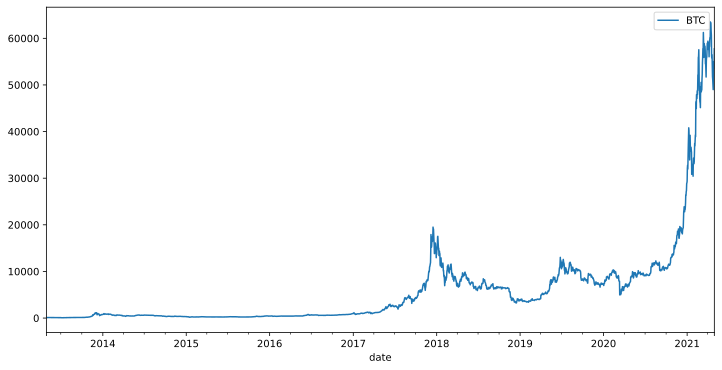

In [4]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

folder = f'../02.Prepared_data/2021-05-01/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df


coins = load_coins(folder)
BTC = pd.DataFrame()
BTC['BTC'] = coins['BTC']

BTC.loc[:].plot(figsize=(12,6))
BTC.head()

path = '../01.Original_data/time_series_course_Data/'
data_passengers = pd.read_csv(f"{path}airline_passengers.csv", parse_dates=True, index_col=0)
data_passengers.index.freq = 'MS'
data_births = pd.read_csv(f"{path}daily_female_births.csv", parse_dates=True, index_col=0)
data_births.index.freq = 'D'

data_samples = pd.read_csv(f"{path}samples.csv", parse_dates=True, index_col=0)
data_samples.index.freq = 'MS'
data_trade = pd.read_csv(f"{path}TradeInventories.csv", parse_dates=True, index_col="Date")
data_trade.index.freq = 'MS'


df_m2 = pd.read_csv(f"{path}M2SLMoneyStock.csv", parse_dates=True, index_col=0)
df_m2.index.freq = 'MS'

df_personal = pd.read_csv(f"{path}PCEPersonalSpending.csv", parse_dates=True, index_col=0)
df_personal.index.freq = 'MS'

## Combine the data series

In [5]:
df_comb = df_m2.join(df_personal)
df_comb

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1
...,...,...
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1


In [6]:
df_comb.shape

(252, 2)

In [7]:
df_comb.dropna().shape

(252, 2)

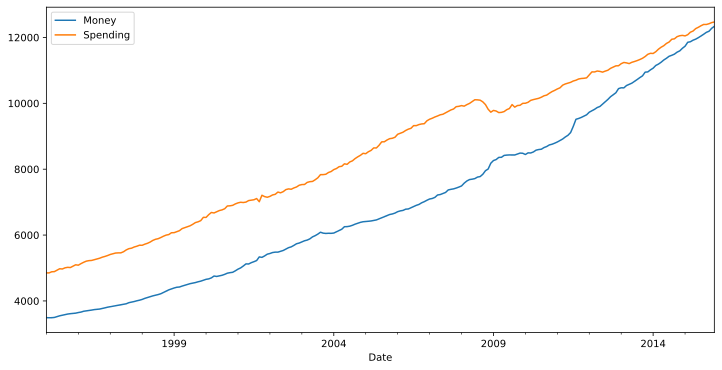

In [8]:
df_comb.plot(figsize=(12,6));

## Test for stationarity and do necessary transformations

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df_comb['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [11]:
adf_test(df_comb['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### First order difference

In [14]:
df_transformed = df_comb.diff() # first differenced

In [15]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [16]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Spending column is now stationary, but money is not

### Second order differencing

It makes sense to always apply the differencing to the whole dataset and not columnwise.

In [17]:
df_transformed2 = df_transformed.diff().dropna()
df_transformed2

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7
...,...,...
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8
2015-10-01,-23.1,24.5


In [18]:
adf_test(df_transformed2['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [19]:
adf_test(df_transformed2['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Both are stationary!

### Choose order of VAR

In [22]:
nobs = 12 # number of observations
train = df_transformed2[:-nobs]
test = df_transformed2[-nobs:]

#### Grid Search for order p AR of VAR model

In [25]:
model = VAR(train)
vals = [1,2,3,4,5,6,7, 10, 20]

for p in vals:
    results = model.fit(p)
    print(f'ORDER {p} --- AIC {results.aic}')
#     print('\n')

ORDER 1 --- AIC 14.178610495220896
ORDER 2 --- AIC 13.955189367163705
ORDER 3 --- AIC 13.849518291541038
ORDER 4 --- AIC 13.827950574458281
ORDER 5 --- AIC 13.78730034460964
ORDER 6 --- AIC 13.799076756885809
ORDER 7 --- AIC 13.797638727913972
ORDER 10 --- AIC 13.806012266239211
ORDER 20 --- AIC 14.046146932644335


In [27]:
results = model.fit(maxlags=5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 09, May, 2021
Time:                     12:35:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

#### Predict the next 12 values

We need a 5 x 2 array, because maxlags is 5 and we have two time series.

In [30]:
# Grab 5 lag values right before the test set starts
lagged_values = train.values[-5:]

In [32]:
z = results.forecast(y=lagged_values, steps=nobs)
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

These are in second order differenced, so they do not make much sense.

#### Transform back - Reverse the differencing

In [33]:
idx = pd.date_range("2015-01-01", periods=nobs, freq='MS') # where the test set starts

In [34]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [35]:
idx

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [38]:
df_forecast = pd.DataFrame(data=z, index=idx, columns=['Money2d', "Spending2d"])

In [39]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df_comb['Money'].iloc[-nobs-1]-df_comb['Money'].iloc[-nobs-2]) + df_forecast['Money2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df_comb['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [40]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df_comb['Spending'].iloc[-nobs-1]-df_comb['Spending'].iloc[-nobs-2]) + df_forecast['Spending2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df_comb['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [41]:
df_forecast.head()

,Money2d,Spending2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


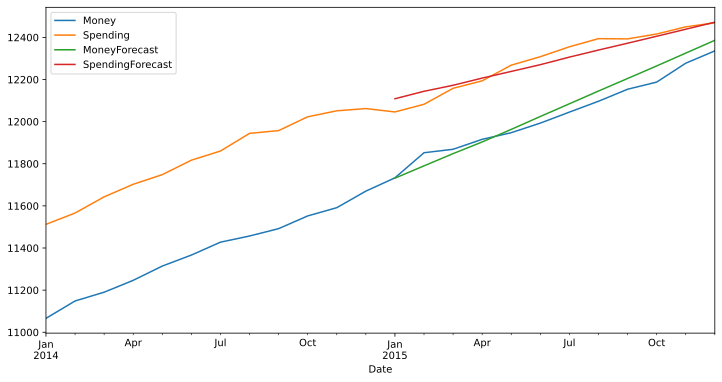

In [48]:
start = '2014'
df_comb.loc[start:].plot(figsize=(12,6), legend=True);
df_forecast['MoneyForecast'].plot(legend=True);
df_forecast['SpendingForecast'].plot(legend=True);

In [51]:
test_range = df_comb[-nobs:]


In [57]:
rmse(test_range['Money'], df_forecast['MoneyForecast']), test_range['Money'].mean(), test_range['Money'].std()

(43.71049653558893, 12034.008333333333, 182.46365744410235)

In [56]:
rmse(test_range['Spending'], df_forecast['SpendingForecast']), test_range['Spending'].mean(), test_range['Spending'].std()

(37.001175169408285, 12294.533333333335, 144.30775404942014)

# Vector AutoRegression Moving Average - VARMA

Same as with ARMA, apply a moving average term to the model term.